In [1]:
from algorithms import *


=== Solver: CG - Synthetic Data ===
Best C: 1000.0


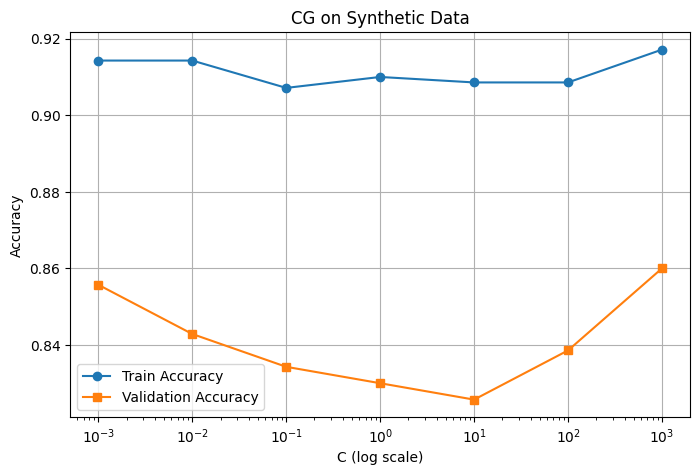

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       139
           1       0.86      0.86      0.86       161

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300

ROC AUC: 0.8525403279860584
Precision: 0.8633540372670807
Recall: 0.8633540372670807
Weight norm: 1.6568102329304322

=== Solver: CG - Real Data ===
Best C: 0.001


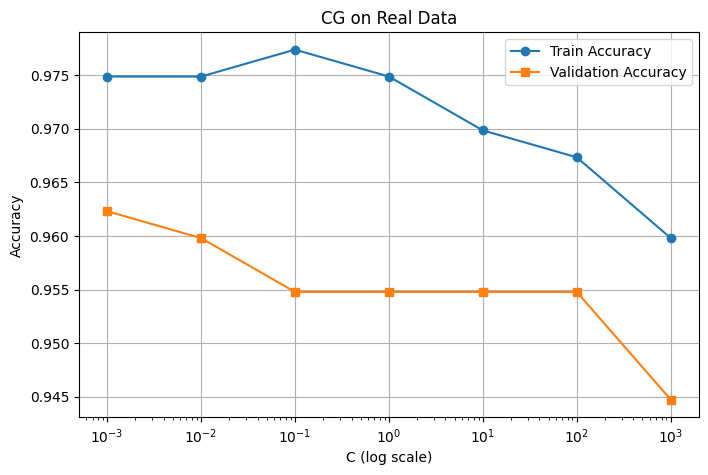

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        63
           1       0.95      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

ROC AUC: 0.9417989417989417
Precision: 0.9541284403669725
Recall: 0.9629629629629629
Weight norm: 0.2812933007838386

=== Solver: LBFGS - Synthetic Data ===
Best C: 1000.0


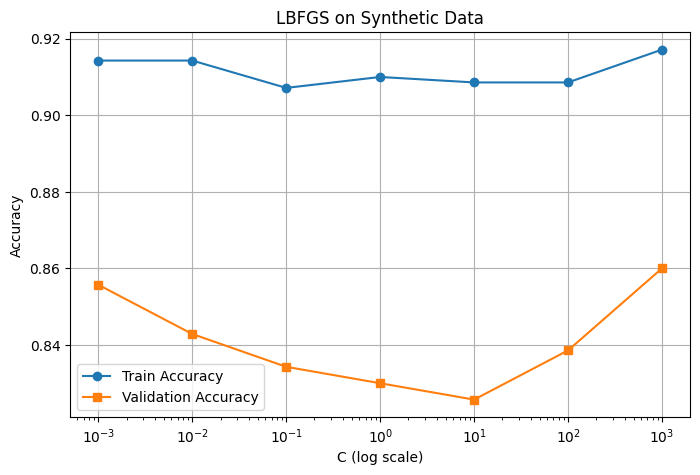

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       139
           1       0.86      0.86      0.86       161

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300

ROC AUC: 0.8525403279860584
Precision: 0.8633540372670807
Recall: 0.8633540372670807
Weight norm: 1.6568102329304322

=== Solver: LBFGS - Real Data ===
Best C: 0.001


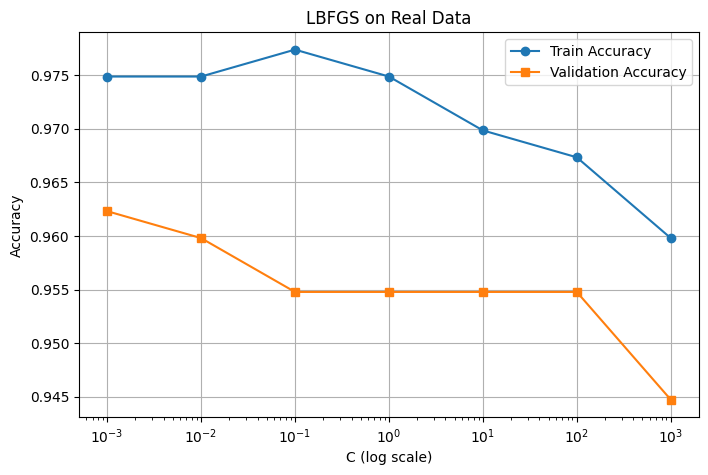

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        63
           1       0.95      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

ROC AUC: 0.9417989417989417
Precision: 0.9541284403669725
Recall: 0.9629629629629629
Weight norm: 0.2812933007838386

=== Solver: TRON - Synthetic Data ===
Best C: 1000.0


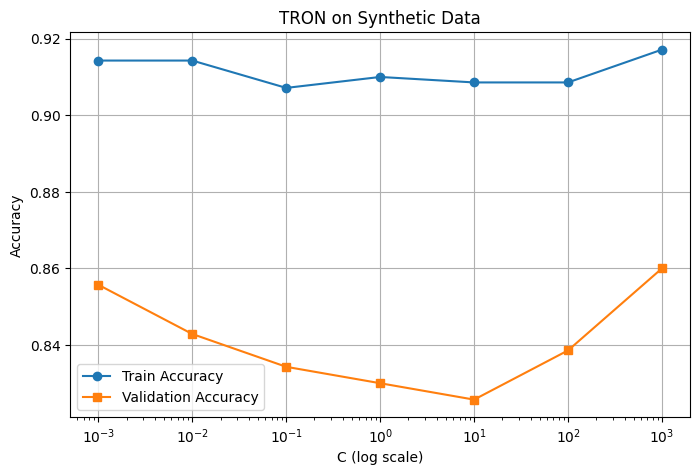

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       139
           1       0.86      0.86      0.86       161

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300

ROC AUC: 0.8525403279860584
Precision: 0.8633540372670807
Recall: 0.8633540372670807
Weight norm: 1.6568102329304322

=== Solver: TRON - Real Data ===
Best C: 0.001


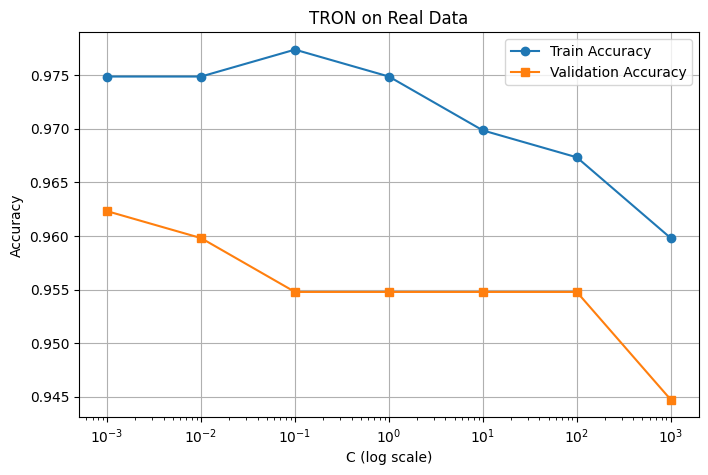

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        63
           1       0.95      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

ROC AUC: 0.9417989417989417
Precision: 0.9541284403669725
Recall: 0.9629629629629629
Weight norm: 0.2812933007838386


In [2]:
import numpy as np
import pandas as pd
import time

from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


def test_solvers():
    X_syn, y_syn = make_classification(
        n_samples=1000, n_features=200, 
        n_informative=30, n_redundant=2,
        n_classes=2, random_state=42, class_sep=2.0,
    )
    data = load_breast_cancer()
    X_real, y_real = data.data, data.target

    scaler = StandardScaler()
    X_syn = scaler.fit_transform(X_syn)
    X_real = scaler.fit_transform(X_real)

    print(np.min(np.std(X_syn, axis=0)))

    from scipy.sparse import issparse
    from scipy.sparse import csr_matrix

    X_real_sparse= csr_matrix(X_real)
    X_syn_sparse = csr_matrix(X_syn)
    print(issparse(X_real_sparse))  # Zwraca True jeśli X to macierz rzadka
    print(issparse(X_syn_sparse))  # Zwraca True jeśli X to macierz rzadka

    X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
        X_syn, y_syn, test_size=0.3, random_state=1)
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_real, y_real, test_size=0.3, random_state=1)

    solvers = ['cg', 'lbfgs']
    results = []

    for solver in solvers:
        clf = SquaredHingeClassifier(C=1.0, solver=solver)


        #synthetic data
        t0 = time.time()
        clf.fit(X_syn_train, y_syn_train)
        t_syn = time.time() - t0
        y_syn_pred = clf.predict(X_syn_test)
        acc_syn = accuracy_score(y_syn_test, y_syn_pred)

        #real data
        t0 = time.time()
        clf.fit(X_real_train, y_real_train)
        t_real = time.time() - t0
        y_real_pred = clf.predict(X_real_test)
        acc_real = accuracy_score(y_real_test, y_real_pred)

        results.append({
            'solver': solver,
            'syn_accuracy': acc_syn,
            'syn_time_s': t_syn,
            'real_accuracy': acc_real,
            'real_time_s': t_real
        })

    df = pd.DataFrame(results)
    print(df)
    print("\nSynthetic Data ")
    for solver in solvers:
        clf = SquaredHingeClassifier(C=1.0, solver=solver)
        clf.fit(X_syn_train, y_syn_train)
        print(f"\nSolver = {solver}")
        print(classification_report(y_syn_test, clf.predict(X_syn_test)))
    
    print("\nReal Data:")
    for solver in solvers:
        clf = SquaredHingeClassifier(C=1.0, solver=solver)
        clf.fit(X_real_train, y_real_train)
        print(f"\nSolver = {solver}")
        print(classification_report(y_real_test, clf.predict(X_real_test)))


def test_solvers2():
    X_syn, y_syn = make_classification(n_samples=1000, n_features=200,
                                       n_informative=30, n_redundant=2,
                                       n_classes=2, random_state=42, class_sep=2.0)
    data = load_breast_cancer()
    X_real, y_real = data.data, data.target

    scaler = StandardScaler()
    X_syn = scaler.fit_transform(X_syn)
    X_real = scaler.fit_transform(X_real)

    X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=1)
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, test_size=0.3, random_state=1)

    solvers = ['cg', 'lbfgs', 'tron']

    for solver in solvers:
        print(f"\n=== Solver: {solver.upper()} - Synthetic Data ===")
        grid = cross_validate_C(X_syn_train, y_syn_train, solver=solver)
        print("Best C:", grid.best_params_['C'])
        plot_train_val_error(grid, title=f"{solver.upper()} on Synthetic Data")
        evaluate_model(grid.best_estimator_, X_syn_test, y_syn_test)

        print(f"\n=== Solver: {solver.upper()} - Real Data ===")
        grid = cross_validate_C(X_real_train, y_real_train, solver=solver)
        print("Best C:", grid.best_params_['C'])
        plot_train_val_error(grid, title=f"{solver.upper()} on Real Data")
        evaluate_model(grid.best_estimator_, X_real_test, y_real_test)

        


if __name__ == "__main__":
    #test_solvers()
    test_solvers2()



=== Solver: CG - Synthetic Data ===
Best C: 0.1


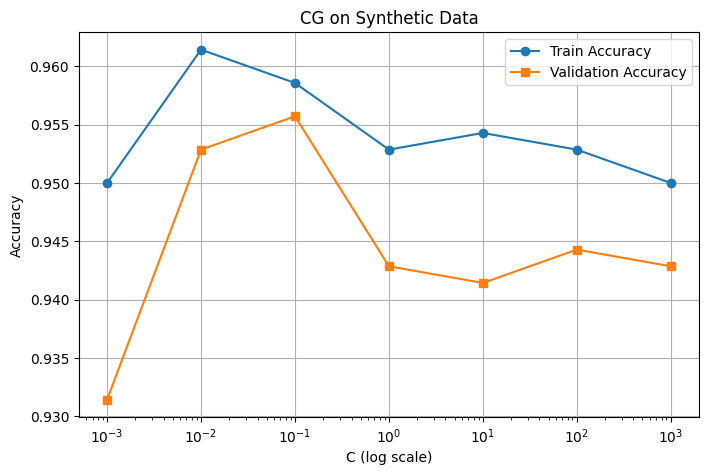

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96       153
           1       0.92      0.99      0.96       147

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

ROC AUC: 0.9573829531812725
Precision: 0.9240506329113924
Recall: 0.9931972789115646
Weight norm: 1.4428215414456171
Starting Conjugate Gradient optimization...
Initial gradient norm: 8.924887e+01
Iter   0: loss = 5.742047e+01, grad_norm = 7.056526e+01, alpha = 1.854831e-02
Iter  10: loss = 3.746704e+01, grad_norm = 2.841025e+00, alpha = 7.736926e-02
Iter  20: loss = 3.660290e+01, grad_norm = 3.818878e-01, alpha = 1.658730e-02
Iter  30: loss = 3.659860e+01, grad_norm = 1.990064e-02, alpha = 2.996087e-02
Iter  40: loss = 3.659857e+01, grad_norm = 1.529140e-03, alpha = 1.291216e-02
Converged at iteration 42, gradient norm: 9.447504e-04
Optimiz

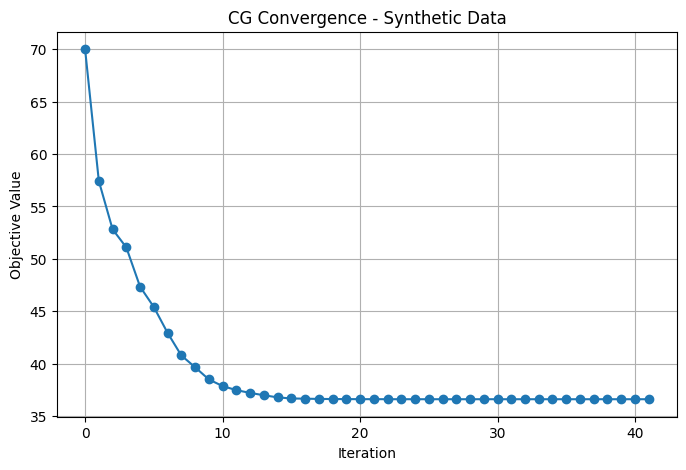


=== Solver: CG - Real Data ===
Best C: 0.001


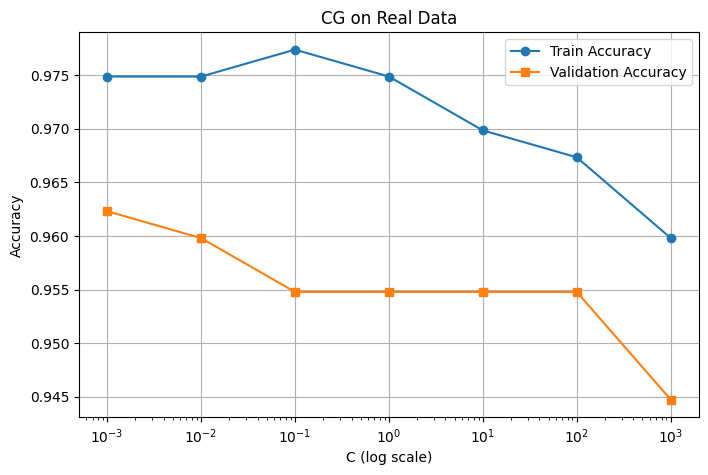

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        63
           1       0.95      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

ROC AUC: 0.9417989417989417
Precision: 0.9541284403669725
Recall: 0.9629629629629629
Weight norm: 0.2812933007838386
Starting Conjugate Gradient optimization...
Initial gradient norm: 1.145832e+00
Iter   0: loss = 2.879077e-01, grad_norm = 4.451107e-01, alpha = 3.656140e-01
Converged at iteration 7, gradient norm: 9.781129e-04
Optimization completed in 0.001 seconds
Final loss: 2.473751e-01
Final gradient norm: 9.781129e-04
Training completed in 0.00 seconds. Final loss: 0.2474


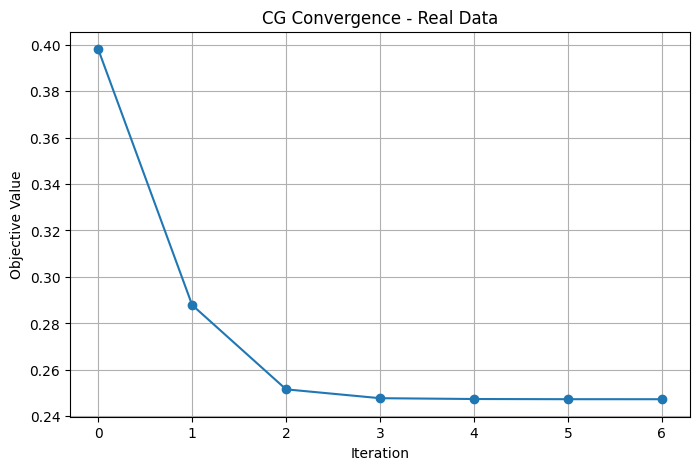


=== Solver: LBFGS - Synthetic Data ===
Best C: 0.1


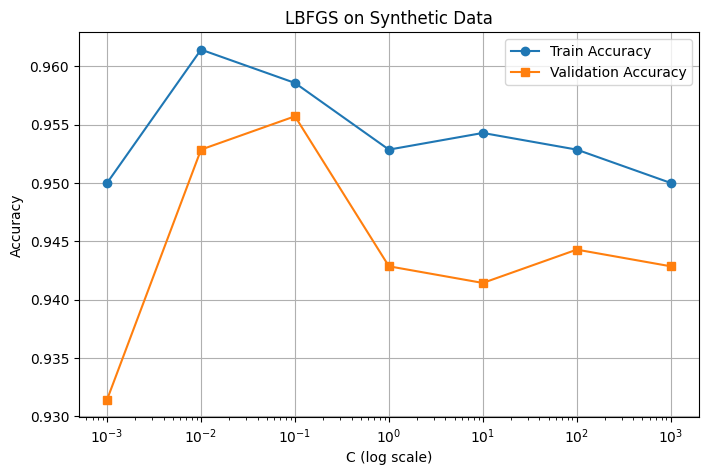

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96       153
           1       0.92      0.99      0.96       147

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

ROC AUC: 0.9573829531812725
Precision: 0.9240506329113924
Recall: 0.9931972789115646
Weight norm: 1.4428215414456171
Training completed in 0.00 seconds. Final loss: 36.5986


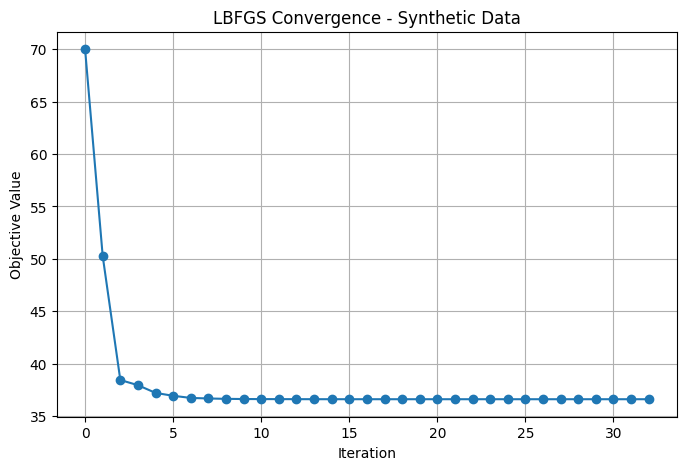


=== Solver: LBFGS - Real Data ===
Best C: 0.001


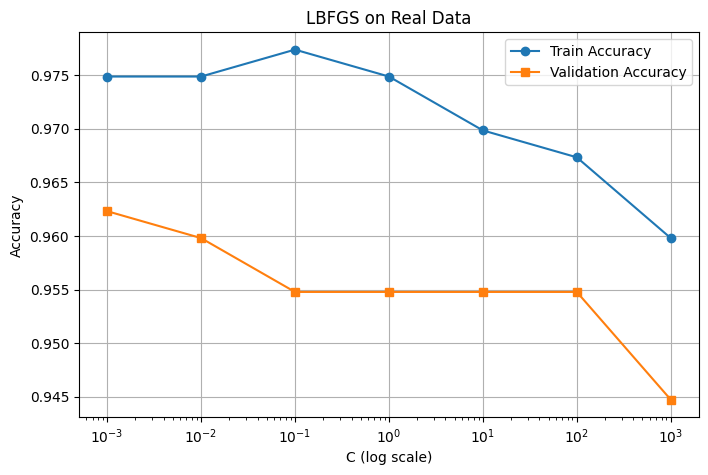

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        63
           1       0.95      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

ROC AUC: 0.9417989417989417
Precision: 0.9541284403669725
Recall: 0.9629629629629629
Weight norm: 0.2812933007838386
Training completed in 0.00 seconds. Final loss: 0.2474


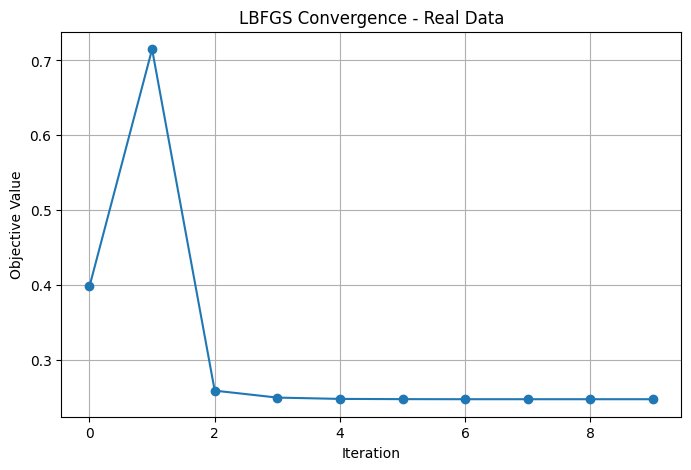


=== Solver: TRON - Synthetic Data ===
Best C: 0.1


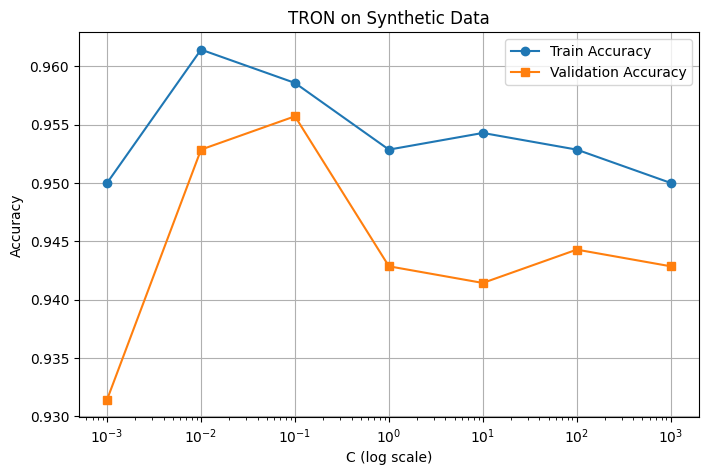

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96       153
           1       0.92      0.99      0.96       147

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

ROC AUC: 0.9573829531812725
Precision: 0.9240506329113924
Recall: 0.9931972789115646
Weight norm: 1.4428215414456171
Training completed in 0.04 seconds. Final loss: 36.5986


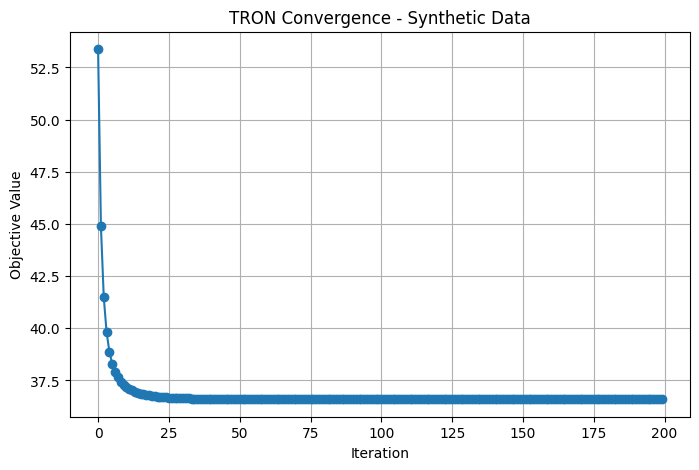


=== Solver: TRON - Real Data ===
Best C: 0.001


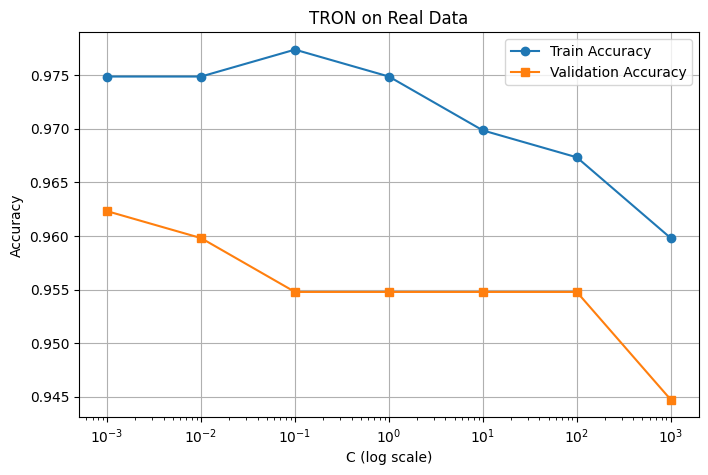

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        63
           1       0.95      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

ROC AUC: 0.9417989417989417
Precision: 0.9541284403669725
Recall: 0.9629629629629629
Weight norm: 0.2812933007838386
Training completed in 0.00 seconds. Final loss: 0.2474


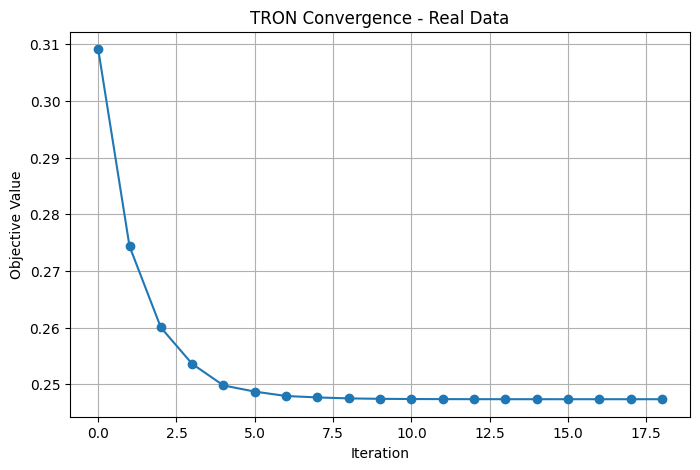

In [3]:
def test_solvers2():
    X_syn, y_syn = make_classification(n_samples=1000, n_features=50,
                                       n_informative=10, n_redundant=2,
                                       n_classes=2, random_state=42, class_sep=2.0)
    data = load_breast_cancer()
    X_real, y_real = data.data, data.target

    scaler = StandardScaler()
    X_syn = scaler.fit_transform(X_syn)
    X_real = scaler.fit_transform(X_real)

    X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=1)
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, test_size=0.3, random_state=1)

    solvers = ['cg', 'lbfgs', 'tron']

    for solver_name in solvers:
        print(f"\n=== Solver: {solver_name.upper()} - Synthetic Data ===")

        # Grid search for best C
        grid = cross_validate_C(X_syn_train, y_syn_train, solver=solver_name)
        best_C = grid.best_params_['C']
        print("Best C:", best_C)
        plot_train_val_error(grid, title=f"{solver_name.upper()} on Synthetic Data")
        evaluate_model(grid.best_estimator_, X_syn_test, y_syn_test)

        # Train for convergence plot
        if solver_name == 'cg':
            solver = ConjugateGradientSolver(max_iter=1000, tol=1e-3)
        elif solver_name == 'lbfgs':
            solver = LBFGSSolver()
        elif solver_name == 'tron':
            solver = TrustRegionNewtonSolver()
        else:
            continue  # Unknown solver, skip

        w, loss, duration, loss_history = solver.solve(X_syn_train, y_syn_train, C=best_C)
        print(f"Training completed in {duration:.2f} seconds. Final loss: {loss:.4f}")
        plot_convergence(loss_history, title=f"{solver_name.upper()} Convergence - Synthetic Data", xscale='linear')

        print(f"\n=== Solver: {solver_name.upper()} - Real Data ===")
        grid = cross_validate_C(X_real_train, y_real_train, solver=solver_name)
        best_C = grid.best_params_['C']
        print("Best C:", best_C)
        plot_train_val_error(grid, title=f"{solver_name.upper()} on Real Data")
        evaluate_model(grid.best_estimator_, X_real_test, y_real_test)


        if solver_name == 'cg':
            solver = ConjugateGradientSolver(max_iter=1000, tol=1e-3)
        elif solver_name == 'lbfgs':
            solver = LBFGSSolver()
        elif solver_name == 'tron':
            solver = TrustRegionNewtonSolver()
        else:
            continue

        w, loss, duration, loss_history = solver.solve(X_real_train, y_real_train, C=best_C)
        print(f"Training completed in {duration:.2f} seconds. Final loss: {loss:.4f}")
        plot_convergence(loss_history, title=f"{solver_name.upper()} Convergence - Real Data")

if __name__ == "__main__":
    test_solvers2()
